In [1]:
# This file requires this torch version for reproducibility..., in contrast to the benchmarks which use 1.13.1
!pip install torch==1.13.0+cu116 --extra-index-url https://download.pytorch.org/whl/cu116  --user
import torch
assert torch.__version__ == "1.13.0+cu116", "Please install torch 1.13.0 to reproduce this"

from rbi.models import InverseAffineAutoregressiveModel
from rbi.loss import NLLLoss

from rbibm.tasks import HHTask
from rbibm.tasks.hh_task import SimpleHHTask
import torch 
from torch import nn

import matplotlib.pyplot as plt

seed = 0
torch.manual_seed(seed)

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu116


C:\Users\manug\AppData\Roaming\Python\Python39\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
torch.__version__

'1.13.0+cu116'

In [3]:
colors = ["#08519c", "#d94801"]

In [4]:
task = SimpleHHTask()
prior = task.get_prior()
simulator = task.get_simulator()
train_loader, _,_ = task.get_train_test_val_dataset(10000,0,0)

In [5]:
model = InverseAffineAutoregressiveModel(task.input_dim, task.output_dim, output_transform=torch.distributions.biject_to(prior.support), num_transforms=3, embedding_net=nn.Sequential(nn.Linear(500,200), nn.ReLU(),nn.Linear(200, 200), nn.ReLU(), nn.Linear(200, 50), nn.ReLU()), hidden_dims=[100,100])
loss_fn = NLLLoss(model)

In [6]:
num_epochs = 40
optim = torch.optim.Adam(model.parameters())
for i in range(num_epochs):
    for x, theta in train_loader:
        optim.zero_grad()
        l = loss_fn(x, theta)
        l.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 10.)
        optim.step()
    print(l)

tensor([9.2542], grad_fn=<AddBackward0>)
tensor([8.4607], grad_fn=<AddBackward0>)
tensor([7.8071], grad_fn=<AddBackward0>)
tensor([7.7755], grad_fn=<AddBackward0>)
tensor([8.1016], grad_fn=<AddBackward0>)
tensor([6.8904], grad_fn=<AddBackward0>)
tensor([6.8233], grad_fn=<AddBackward0>)
tensor([6.0251], grad_fn=<AddBackward0>)
tensor([6.2589], grad_fn=<AddBackward0>)
tensor([6.1069], grad_fn=<AddBackward0>)
tensor([6.3163], grad_fn=<AddBackward0>)
tensor([7.6844], grad_fn=<AddBackward0>)
tensor([6.0297], grad_fn=<AddBackward0>)
tensor([5.4683], grad_fn=<AddBackward0>)
tensor([9.2171], grad_fn=<AddBackward0>)
tensor([5.7812], grad_fn=<AddBackward0>)
tensor([5.7043], grad_fn=<AddBackward0>)
tensor([5.1988], grad_fn=<AddBackward0>)
tensor([5.2126], grad_fn=<AddBackward0>)
tensor([5.7353], grad_fn=<AddBackward0>)
tensor([5.7488], grad_fn=<AddBackward0>)
tensor([4.7494], grad_fn=<AddBackward0>)
tensor([5.2045], grad_fn=<AddBackward0>)
tensor([5.3752], grad_fn=<AddBackward0>)
tensor([5.7706],

In [7]:
torch.manual_seed(seed + 1)

In [8]:
thetas = prior.sample((1000,))
xs = simulator(thetas)

In [9]:
from rbibm.metric.robustness_metric import ReverseKLRobMetric, ReverseKLLoss
from rbi.attacks import LinfPGDAdamAttack

In [10]:
attack = LinfPGDAdamAttack(model, ReverseKLLoss(mc_samples=5), eps=3., eps_iter=0.1, nb_iter=200)

In [11]:
m = ReverseKLRobMetric(model, attack)

In [12]:
m.eval(xs.contiguous())

tensor(40.4724)

In [13]:
x_idx, x_o_tilde = m.generate_adversarial_examples(xs)

In [14]:
x_o = xs[x_idx[1]].unsqueeze(0)
theta = thetas[x_idx[1]].unsqueeze(0)

In [15]:
x_o_tilde= x_o_tilde[1].unsqueeze(0)

In [16]:
from sbi.analysis import pairplot

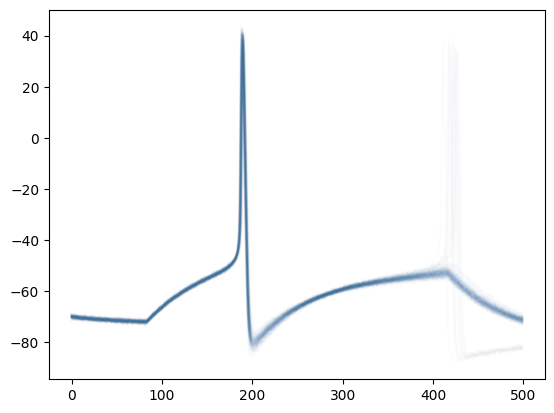

In [17]:
with torch.no_grad():
    q = model(x_o)
_ = plt.plot(simulator(q.sample((100,)).squeeze()).squeeze().T, color=colors[0], alpha=0.01)

C:\Users\manug\AppData\Local\Temp\ipykernel_20300\2393043440.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3281.)
  _ = plt.plot(x_o_tilde[0].T)


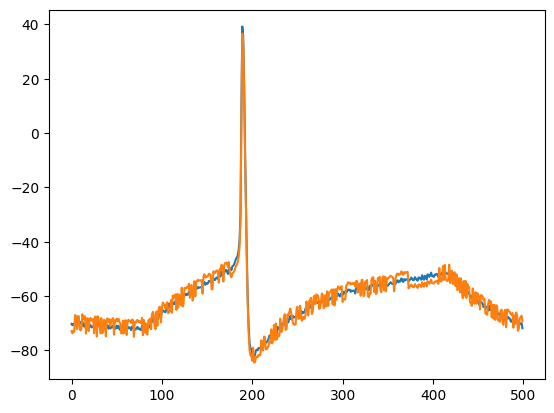

In [18]:
plt.plot(x_o.T)
_ = plt.plot(x_o_tilde[0].T)

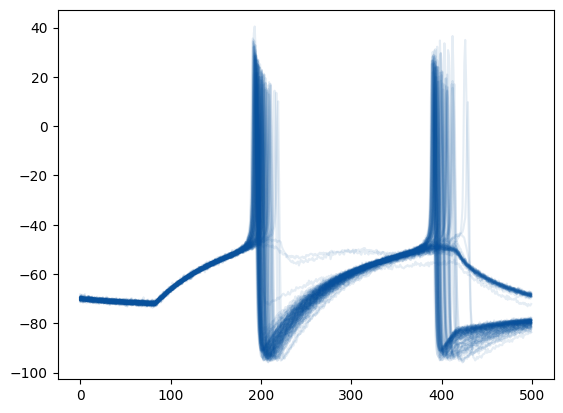

In [19]:
_ = plt.plot(simulator(model(x_o_tilde[0].squeeze()).sample((100,))).detach().T, color=colors[0], alpha=0.1)

In [20]:
delta = x_o_tilde -x_o

C:\Users\manug\AppData\Roaming\Python\Python39\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


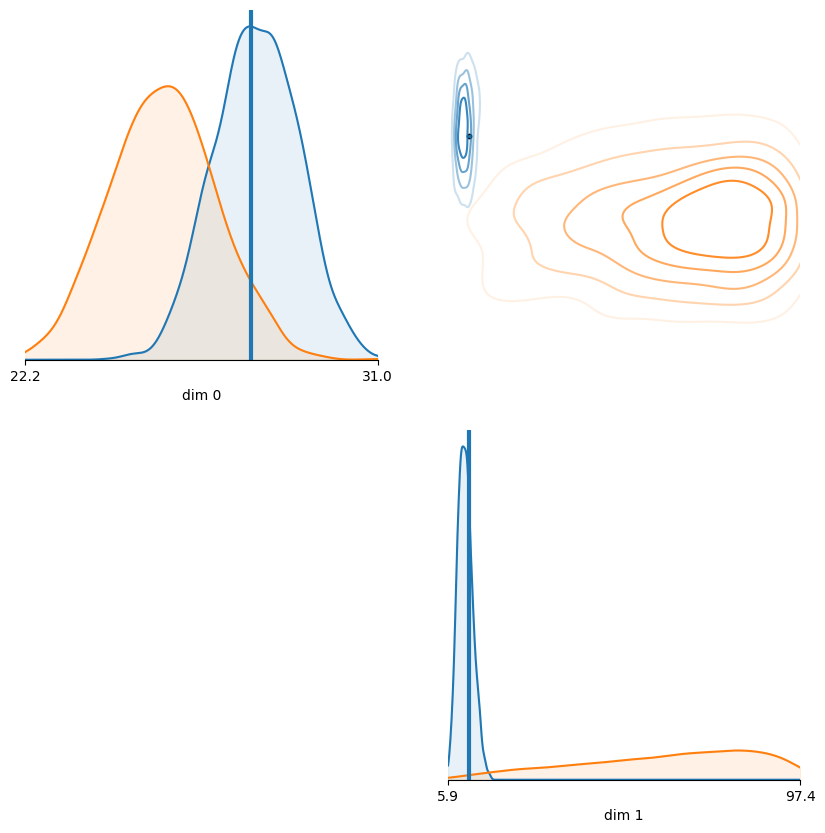

In [21]:
from rbibm.plots.custom_distribution_plots import custom_pairplot, custom_2d_joint_plot
from rbibm.plots.styles import use_style
q = model(x_o)
q_tilde = model(x_o_tilde[0])

_ = custom_pairplot([q.sample((2000,)).squeeze(), q_tilde.sample((2000,)).squeeze()], points=[theta], bins=200)

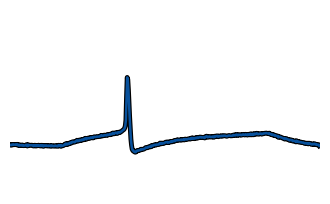

In [22]:
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(4, 2.4))
_ = plt.plot(x_o.T, color=colors[0],lw=1.8,path_effects=[pe.Stroke(linewidth=3.5, foreground='black'), pe.Normal()])
plt.ylim(-150, 150)
plt.xlim(0, 500)
plt.axis("off")
fig.savefig("x.svg", transparent=True)

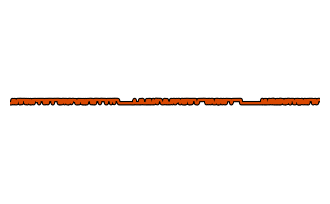

In [23]:
import matplotlib.patheffects as pe
from matplotlib.colors import to_rgb

fig = plt.figure(figsize=(4, 2.4))
_ = plt.plot(delta.T, color=colors[1],lw=1.6,path_effects=[pe.Stroke(linewidth=3.2, foreground='black'), pe.Normal()])
plt.ylim(-150, 150)
plt.xlim(0, 500)
plt.axis("off")
fig.savefig("delta.svg", transparent=True)

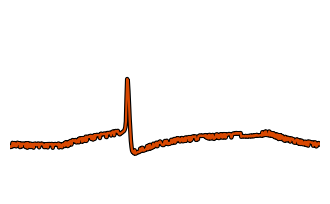

In [24]:
import matplotlib.patheffects as pe
import numpy as np
from matplotlib.colors import to_hex

c = colors[1]

fig = plt.figure(figsize=(4, 2.4))
_ = plt.plot(x_o_tilde.T, color=c,lw=1.6,path_effects=[pe.Stroke(linewidth=3.2, foreground='black'), pe.Normal()])
plt.ylim(-150, 150)
plt.xlim(0, 500)
plt.axis("off")
fig.savefig("x_tilde.svg", transparent=True)

In [25]:
torch.manual_seed(seed + 4)

In [26]:
q = model(x_o)

In [27]:
samples = q.sample((50000,))

In [28]:
import matplotlib as mpl 

C:\Users\manug\AppData\Local\Temp\ipykernel_20300\1515675248.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("post.svg", bbox="tight", transparent=True)


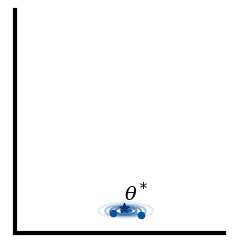

In [29]:
with use_style("pyloric"):
    mpl.rcParams["axes.linewidth"]=3
    fig, axes = custom_2d_joint_plot([samples.squeeze(),],dim1=0, figsize=(3.25,3.5), dim2=1, bins=200,ylim=[0,100], xlim=[20,35], labels=["$\\theta_1$", "$\\theta_2$"], colors=colors)
    sample1 = q.sample()
    sample2 = q.sample()
    axes[0].scatter(theta[:, 0], theta[:, 1],color="black", marker="*", s=50.)
    axes[0].text(theta[:, 0], theta[:, 1] + 3, "$\\theta^*$", fontsize=14)

    axes[0].scatter(sample1[:,0], sample1[:,1], s=20., color=colors[0])
    axes[0].scatter(sample2[:,0], sample2[:,1], s=20., color=colors[0])
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    fig.delaxes(axes[1])
    fig.delaxes(axes[2])
    axes[0].set_ylabel("")
    axes[0].set_xlabel("")

fig.savefig("post.svg", bbox="tight", transparent=True)

In [30]:
x_pred1 = simulator(sample1)
x_pred2 = simulator(sample2)

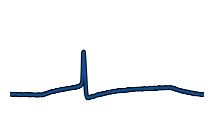

In [31]:
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(2.5, 1.5))
_ = plt.plot(x_pred1.T, color=colors[0],lw=1.6,path_effects=[pe.Stroke(linewidth=3.2, foreground='black'), pe.Normal()])
plt.ylim(-150, 150)
plt.xlim(0, 500)
plt.axis("off")
fig.savefig("x_pred1.svg", transparent=True)

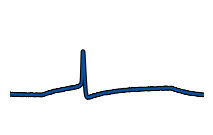

In [32]:
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(2.5, 1.5))
_ = plt.plot(x_pred2.T, color=colors[0],lw=1.6,path_effects=[pe.Stroke(linewidth=3.2, foreground='black'), pe.Normal()])
plt.ylim(-150, 150)
plt.xlim(0, 500)
plt.axis("off")
fig.savefig("x_pred2.svg", transparent=True)

In [33]:
q = model(x_o_tilde)
samples = q.sample((50000,))

In [34]:
from matplotlib.colors import to_hex

In [35]:
torch.manual_seed(seed+8)

C:\Users\manug\AppData\Local\Temp\ipykernel_20300\2071691215.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("adversarial_post.svg", bbox="tight", transparent=True)


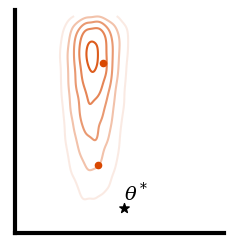

In [36]:
with use_style("pyloric"):
    mpl.rcParams["axes.linewidth"]=3
    fig, axes = custom_2d_joint_plot([samples.squeeze(),],dim1=0, dim2=1,figsize=(3.25,3.5), bins=200,ylim=[0,100], xlim=[20,35], labels=["$\\theta_1$", "$\\theta_2$"], colors=[c])
    sample1 = q.sample()
    sample2 = q.sample()
    axes[0].scatter(theta[:, 0], theta[:, 1],color="black", marker="*", s=50.)
    axes[0].text(theta[:, 0], theta[:, 1] + 3, "$\\theta^*$", fontsize=14)

    axes[0].scatter(sample1[:,0], sample1[:,1], s=20., color=c)
    axes[0].scatter(sample2[:,0], sample2[:,1], s=20., color=c)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    fig.delaxes(axes[1])
    fig.delaxes(axes[2])
    axes[0].set_ylabel("")
    axes[0].set_xlabel("")

fig.savefig("adversarial_post.svg", bbox="tight", transparent=True)

In [37]:
x_pred1 = simulator(sample1)
x_pred2 = simulator(sample2)

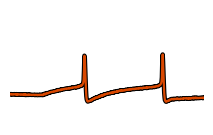

In [38]:
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(2.5, 1.5))
_ = plt.plot(x_pred1.T, color=c,lw=1.6,path_effects=[pe.Stroke(linewidth=3.2, foreground='black'), pe.Normal()])
plt.ylim(-150, 150)
plt.xlim(0, 500)
plt.axis("off")
fig.savefig("x_tilde_pred1.svg", transparent=True)

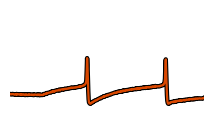

In [39]:
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(2.5, 1.5))
_ = plt.plot(x_pred2.T, color=c,lw=1.6,path_effects=[pe.Stroke(linewidth=3.2, foreground='black'), pe.Normal()])
plt.ylim(-150, 150)
plt.xlim(0, 500)
plt.axis("off")
fig.savefig("x_tilde_pred2.svg", transparent=True)

In [40]:
from rbi.defenses import FIMTraceRegularizer
torch.manual_seed(seed)

model2 = InverseAffineAutoregressiveModel(task.input_dim, task.output_dim, output_transform=torch.distributions.biject_to(prior.support), num_transforms=3, embedding_net=nn.Sequential(nn.Linear(500,200), nn.ReLU(),nn.Linear(200, 200), nn.ReLU(), nn.Linear(200, 50), nn.ReLU()), hidden_dims=[100,100])
loss_fn2 = NLLLoss(model2)
defenses = FIMTraceRegularizer(model2, loss_fn2, algorithm="ema", beta=10., ema_mc_samples=10)
defenses.activate()

In [41]:
num_epochs = 40
optim = torch.optim.Adam(model2.parameters())
for i in range(num_epochs):
    for x, theta in train_loader:
        optim.zero_grad()
        l = loss_fn2(x, theta)
        l.backward()
        torch.nn.utils.clip_grad_norm_(model2.parameters(), 10.)
        optim.step()
    print(l)

tensor([9.0664], grad_fn=<AddBackward0>)
tensor([8.4587], grad_fn=<AddBackward0>)
tensor([7.8376], grad_fn=<AddBackward0>)
tensor([7.6810], grad_fn=<AddBackward0>)
tensor([6.9377], grad_fn=<AddBackward0>)
tensor([6.9363], grad_fn=<AddBackward0>)
tensor([6.1341], grad_fn=<AddBackward0>)
tensor([6.1929], grad_fn=<AddBackward0>)
tensor([6.2577], grad_fn=<AddBackward0>)
tensor([6.5421], grad_fn=<AddBackward0>)
tensor([5.7939], grad_fn=<AddBackward0>)
tensor([6.2937], grad_fn=<AddBackward0>)
tensor([6.0694], grad_fn=<AddBackward0>)
tensor([5.3013], grad_fn=<AddBackward0>)
tensor([5.9437], grad_fn=<AddBackward0>)
tensor([6.6832], grad_fn=<AddBackward0>)
tensor([6.0571], grad_fn=<AddBackward0>)
tensor([5.5122], grad_fn=<AddBackward0>)
tensor([5.7705], grad_fn=<AddBackward0>)
tensor([5.2378], grad_fn=<AddBackward0>)
tensor([5.6920], grad_fn=<AddBackward0>)
tensor([5.6457], grad_fn=<AddBackward0>)
tensor([5.1385], grad_fn=<AddBackward0>)
tensor([5.7461], grad_fn=<AddBackward0>)
tensor([4.9894],

In [42]:
attack = LinfPGDAdamAttack(model, ReverseKLLoss(mc_samples=5), eps=3., eps_iter=0.1, nb_iter=200)

In [43]:
x_o_tilde2 = attack.perturb(x_o)

In [44]:
q = model2(x_o)
samples = q.sample((50000,))

In [45]:
theta = thetas[x_idx[1]].unsqueeze(0)

C:\Users\manug\AppData\Local\Temp\ipykernel_20300\3893230416.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("rob_post.svg", bbox="tight", transparent=True)


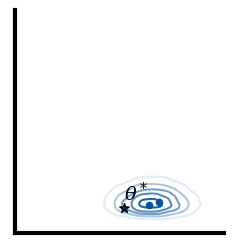

In [46]:
with use_style("pyloric"):
    mpl.rcParams["axes.linewidth"]=3
    fig, axes = custom_2d_joint_plot([samples.squeeze(),],dim1=0, dim2=1,figsize=(3.25,3.5), bins=200,ylim=[0,100], xlim=[20,35], labels=["$\\theta_1$", "$\\theta_2$"], colors=colors)
    sample1 = q.sample()
    sample2 = q.sample()
    axes[0].scatter(theta[:, 0], theta[:, 1],color="black", marker="*", s=50.)
    axes[0].text(theta[:, 0], theta[:, 1] + 3, "$\\theta^*$", fontsize=14)

    axes[0].scatter(sample1[:,0], sample1[:,1], s=20., color=colors[0])
    axes[0].scatter(sample2[:,0], sample2[:,1], s=20., color=colors[0])
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    fig.delaxes(axes[1])
    fig.delaxes(axes[2])
    axes[0].set_ylabel("")
    axes[0].set_xlabel("")

fig.savefig("rob_post.svg", bbox="tight", transparent=True)

In [47]:
q = model2(x_o_tilde2)
samples = q.sample((50000,))

In [48]:
torch.manual_seed(seed+8)

In [49]:
sample1 = q.sample()
sample2 = q.sample()

In [50]:
x_pred1 = simulator(sample1)
x_pred2 = simulator(sample2)

C:\Users\manug\AppData\Local\Temp\ipykernel_20300\3548204906.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("rob_adversarial_post.svg", bbox="tight", transparent=True)


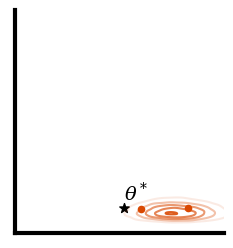

In [51]:
with use_style("pyloric"):
    mpl.rcParams["axes.linewidth"]=3
    fig, axes = custom_2d_joint_plot([samples.squeeze(),],dim1=0, dim2=1,figsize=(3.25,3.5), bins=200,ylim=[0,100], xlim=[20,35], labels=["$\\theta_1$", "$\\theta_2$"], colors=[c])
    axes[0].scatter(theta[:, 0], theta[:, 1],color="black", marker="*", s=50.)
    axes[0].text(theta[:, 0], theta[:, 1] + 3, "$\\theta^*$", fontsize=14)

    axes[0].scatter(sample1[:,0], sample1[:,1], s=20., color=c)
    axes[0].scatter(sample2[:,0], sample2[:,1], s=20., color=c)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    fig.delaxes(axes[1])
    fig.delaxes(axes[2])
    axes[0].set_ylabel("")
    axes[0].set_xlabel("")

fig.savefig("rob_adversarial_post.svg", bbox="tight", transparent=True)

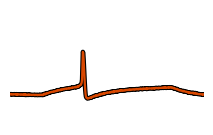

In [52]:
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(2.5, 1.5))
_ = plt.plot(x_pred1.T, color=c,lw=1.6,path_effects=[pe.Stroke(linewidth=3.2, foreground='black'), pe.Normal()])
plt.ylim(-150, 150)
plt.xlim(0, 500)
plt.axis("off")
fig.savefig("rob_x_pred1.svg", transparent=True)

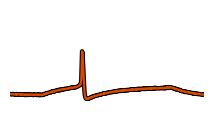

In [53]:
import matplotlib.patheffects as pe

fig = plt.figure(figsize=(2.5, 1.5))
_ = plt.plot(x_pred2.T, color=c,lw=1.6,path_effects=[pe.Stroke(linewidth=3.2, foreground='black'), pe.Normal()])
plt.ylim(-150, 150)
plt.xlim(0, 500)
plt.axis("off")
fig.savefig("rob_x_pred2.svg", transparent=True)

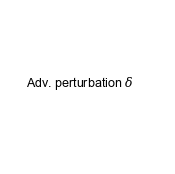

In [54]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(2,2))
    plt.text(0.1,0.5, "Adv. perturbation $\\delta$", font="Arial")
    plt.axis("off")
fig.savefig("adversarial_pert_text.svg", transparent=True)

<Figure size 200x200 with 0 Axes>

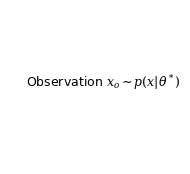

In [55]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(2,2))
    fig = plt.figure(figsize=(2,2))
    plt.text(0.1,0.5, "Observation $x_o \\sim p(x|\\theta^*)$")
    plt.axis("off")
fig.savefig("x_o_text.svg", transparent=True)

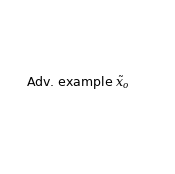

In [56]:

with use_style("pyloric"):
    fig = plt.figure(figsize=(2,2))
    plt.text(0.1,0.5, "Adv. example $\\tilde{x}_o$")
    plt.axis("off")
fig.savefig("x_tilde_text.svg", transparent=True)

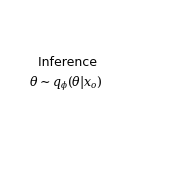

In [57]:

with use_style("pyloric"):
    fig = plt.figure(figsize=(2,2))
    plt.text(0.1,0.5, "   Inference\n $\\theta \\sim q_\\phi(\\theta|x_o)$", linespacing=1.5)
    plt.axis("off")
fig.savefig("inference.svg", transparent=True)

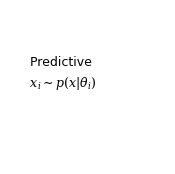

In [58]:

with use_style("pyloric"):
    fig = plt.figure(figsize=(2,2))
    plt.text(0.1,0.5, " Predictive\n $x_i \\sim p(x|\\theta_i)$", linespacing=1.5)
    plt.axis("off")
fig.savefig("predictive.svg", transparent=True)

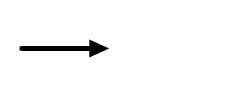

In [59]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(3,1))
    plt.arrow(0.1, 0.5, 0.6,0, color="black", lw=3, head_width=.15, head_length=0.11)
    plt.xlim(0,2)
    plt.ylim(0,1)
    plt.axis("off")
    fig.savefig("arrow.svg", transparent=True)

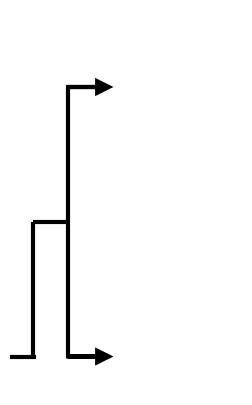

In [60]:
with use_style("pyloric"):
    fig = plt.figure(figsize=(3,5))
    plt.arrow(0.5, 8, 0.25,0, color="black", lw=3, head_width=.3, head_length=0.1)
    plt.arrow(0.5, 1, 0.25,0, color="black", lw=3, head_width=.3, head_length=0.1)
    plt.vlines(0.5,1,8, color="black", lw=3)
    plt.hlines(4.5,0.2,0.5, color="black", lw=3)
    plt.vlines(0.2,1,4.5, color="black", lw=3)
    plt.hlines(1,0.,0.22, color="black", lw=3)
    plt.xlim(0,2)
    plt.ylim(0,10)
    plt.axis("off")
    fig.savefig("strange_arrow.svg", transparent=True)